# IPML Project: Implementing CNN model from scratch

# Creating Custom CNN (VR-Net)

In [1]:
# Importing necessary libraries
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
# Saving the path for train data
trainDir = "/kaggle/input/c/state-farm-distracted-driver-detection/imgs/train"
testDir = "/kaggle/input/c/state-farm-distracted-driver-detection/imgs/test"
# Saving the path for models
modelPath = "/kaggle/working/model"


# Pre-processing the data

In [3]:
def increaseBrightness(img, value):
    # Converting BGR to HSV space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Splitting into individual channels as we need to deal with brightness i.e. "v"
    h, s, v = cv2.split(hsv)

    # Just making sure the value doesn't exceed the limit i.e. 255
    lim = 255 - value
    
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    
    # Converting it back to BGR
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [4]:
def changeContrast(img, level):
    # Converting image to PIL object
    img = Image.fromarray(img.astype('uint8'))
    # Calculationg a factor.
    # Multipled by 259 so as to scale the value in the range 0-255
    # Ensures that the pixel values are not clipped, and the full range of 0-255 is used.
    
    # (From grayscale to RBG when multipled by 255 can clip pixels if contrast is high)
    # Thus using maximum value that can be obtained from the formula
    # Y = 0.299 * 255 + 0.587 * 255 + 0.114 * 255 = 259
    factor = (259 * (level + 255)) / (255 * (259 - level))
    
    # Helper function - applying contrast to every pixel
    def contrast(c):
        return int(128 + factor * (c - 128))
    return np.array(img.point(contrast))

In [5]:
def preprocessImg(img):
    img = np.array(img)

    # Randomly setting the order of operations.
    x = secrets.randbelow(2)

    if x == 0:
        #Order 01
        img = increaseBrightness(img, secrets.randbelow(26))
        img = changeContrast(img, secrets.randbelow(51))
    else:
        #Order 02
        img = changeContrast(img, secrets.randbelow(51))
        img = increaseBrightness(img, secrets.randbelow(26))

    # Convert the pixel values back to integer format
    # img = img.astype(np.uint8)
    return img

In [6]:
!pip install split-folders

In [7]:
import splitfolders

mydata = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(mydata, output="mydata",
    seed=1337, ratio=(.7, .1, .2), group_prefix=None, move=False)

Copying files: 22424 files [01:56, 192.91 files/s]


In [8]:
train = '/kaggle/working/mydata/train'
val = '/kaggle/working/mydata/val'
test = '/kaggle/working/mydata/test'

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# batch_size = 128

# train_generator = train_datagen.flow_from_directory(
#         train,
#         target_size=(256, 256),
#         batch_size=128)

# validation_generator = test_datagen.flow_from_directory(
#         val,
#         target_size=(256, 256),
#         batch_size=128)
     

In [9]:
#Initialise the parameters for Augmentation.

# Change RGB to Gray scale there is a parameter
# Also don't augment validation data.
# Also see for Batch Normalization

datagen = ImageDataGenerator(
        rotation_range = 5,
        width_shift_range = 0.02,
        height_shift_range = 0.02,
        shear_range = 0.01,
        zoom_range = 0.05,
        horizontal_flip = False,
        fill_mode = "nearest",
        validation_split = 0.2,
#         color_mode="grayscale",
        preprocessing_function = preprocessImg)

datagen_test = ImageDataGenerator(
    preprocessing_function= preprocessImg
)

In [10]:
train_data = datagen.flow_from_directory(train,
                                        target_size=(224,224), # Image size
                                        batch_size=128, # Batch size
                                        shuffle=True,
                                        class_mode='sparse')

valid_data = datagen_test.flow_from_directory(val,
                                        target_size=(224,224),
                                        batch_size=128,
                                        shuffle=True,
                                        class_mode='sparse')
test_data = datagen_test.flow_from_directory(test,
                                        target_size=(224,224),
                                        batch_size=128,
                                        shuffle=True,
                                        class_mode='sparse')

Found 15692 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.
Found 4495 images belonging to 10 classes.


In [ ]:
print(valid_data[0][0][0])

In [13]:
input_shape=(224,224,3)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda
model = Sequential()

# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3), kernel_initializer='glorot_normal'))
model.add(Lambda(lambda x: tf.image.rgb_to_grayscale(x), input_shape=input_shape))  # convert input images to grayscale

model.add(Conv2D(16, (5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))# add stride 2 to the MaxPooling2D layer
model.add(tf.keras.layers.Dropout(0.3))
model.add(Conv2D(16, (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))
#model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
#model.add(MaxPooling2D((2, 2), strides=(1, 1)))
model.add(Flatten())
# Checking this inference section
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(10, activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 110, 110, 16)      416       
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 55, 55, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 16)       

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [16]:
filepath = os.path.join(modelPath,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
model_history = model.fit(train_data,validation_data = valid_data,epochs=20,shuffle=True,callbacks=callbacks_list)

Epoch 1/20


2023-05-05 12:21:14.303187: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


123/123 [==============================] - ETA: 0s - loss: 2.7117 - accuracy: 0.1321
Epoch 1: val_accuracy improved from -inf to 0.21681, saving model to /kaggle/working/model/distracted-01-0.22.hdf5
123/123 [==============================] - 268s 2s/step - loss: 2.7117 - accuracy: 0.1321 - val_loss: 2.1898 - val_accuracy: 0.2168
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 2.2457 - accuracy: 0.2146
Epoch 2: val_accuracy improved from 0.21681 to 0.37237, saving model to /kaggle/working/model/distracted-02-0.37.hdf5
123/123 [==============================] - 259s 2s/step - loss: 2.2457 - accuracy: 0.2146 - val_loss: 1.7906 - val_accuracy: 0.3724
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 1.9232 - accuracy: 0.3165
Epoch 3: val_accuracy improved from 0.37237 to 0.43630, saving model to /kaggle/working/model/distracted-03-0.44.hdf5
123/123 [==============================] - 263s 2s/step - loss: 1.9232 - accuracy: 0.3165 - val_loss: 1.6697

KeyboardInterrupt: 

NameError: name 'model_history' is not defined

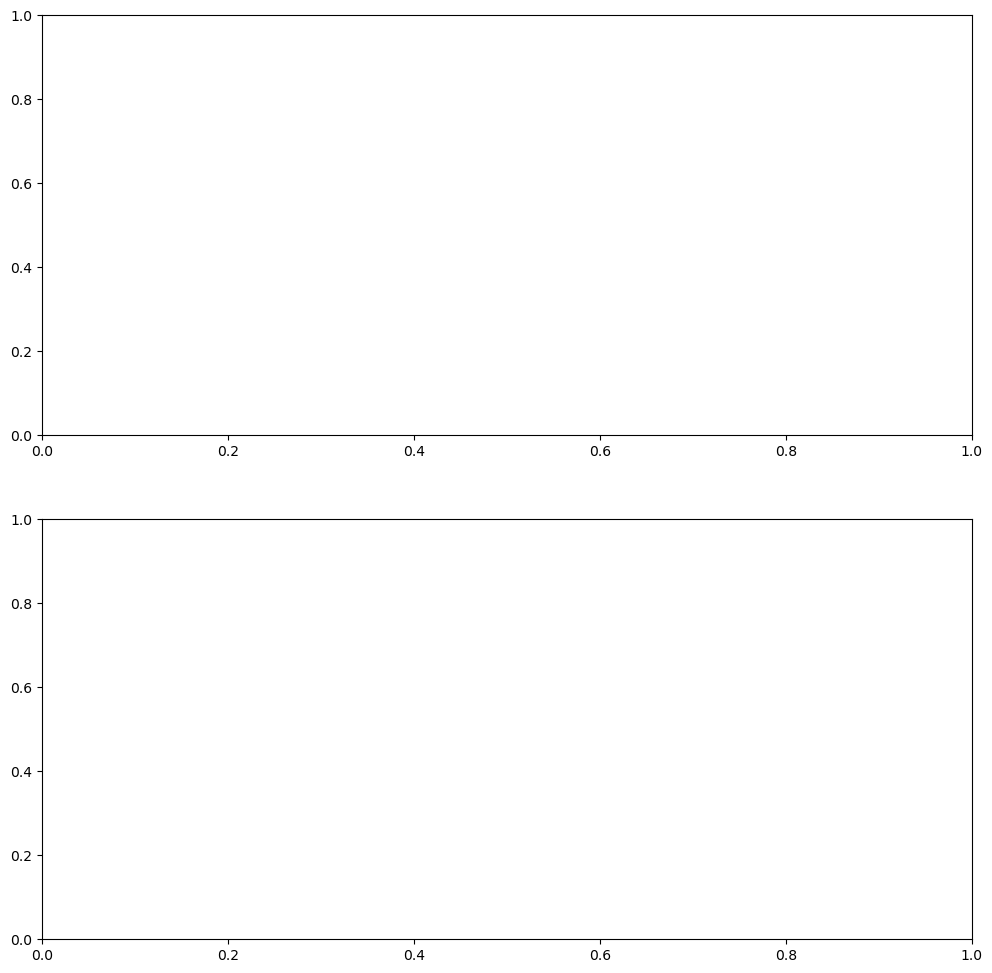

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [27]:
model.evaluate(test_data)

36/36 [==============================] - 35s 969ms/step - loss: 0.4588 - accuracy: 0.8614


[0.458822637796402, 0.8614015579223633]

In [19]:
num_samples = test_data.samples
batch_size = test_data.batch_size

# Initialize empty arrays to store X_test and y_test
X_test = np.empty(shape=(num_samples, 224, 224, 3), dtype=np.float32)
y_test = np.empty(shape=(num_samples,), dtype=np.int32)

# Loop through all batches in the test set and concatenate the results
for i in range(num_samples // batch_size + 1):
    batch_X, batch_y = test_data.next()
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_samples)
    X_test[start_idx:end_idx] = batch_X
    y_test[start_idx:end_idx] = batch_y.ravel()

In [21]:
y_pred = model.predict(X_test)

141/141 [==============================] - 2s 15ms/step


In [25]:
y_pred1 = np.argmax(y_pred,axis=1)

In [26]:
from sklearn.metrics import confusion_matrix
 
cm1 = confusion_matrix(y_test, y_pred1)
print(cm1)

[[406  11  13  38  19   0   5   1   0   6]
 [  0 435  14   4   2   0   0   0   0   0]
 [  0   2 452   1   1   0   8   0   1   0]
 [  1   2   1 462   3   0   0   0   0   1]
 [  4   1  21  10 420   0   6   0   1   3]
 [  6   0   3   2   3 444   4   0   1   0]
 [  2  17  20   1   0   0 424   0   1   1]
 [  1   9  20   0   1   0   1 368   1   0]
 [ 12  16  63   5  10   0  42  20 213   2]
 [ 70  14  20  18  24  15   3   9  10 244]]


In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred1)

0.860511679644049